<a href="https://colab.research.google.com/github/Howuhh/dul_2021/blob/hw7/Homework/hw7/Homework7_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 260 (delta 57), reused 51 (delta 51), pack-reused 171
Receiving objects: 100% (260/260), 53.34 MiB | 32.04 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=22409 sha256=2c55d51efd979b8b879c92113327399c616a42feabfe3db1628ce25387af2361
  Stored in directory: /tmp/pip-ephem-wheel-cache-4chah6tq/wheels/55/59/29/0fb1c635652157734

In [2]:
from dul_2021.utils.hw7_utils import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: GANs on CIFAR-10

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

Files already downloaded and verified


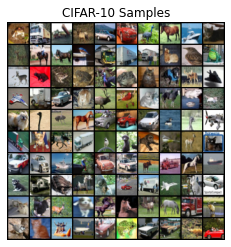

In [ ]:
visualize_q1_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Discriminator loss across training
3. 100 samples. 

In [4]:
import torch
import torch.nn as nn

from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torch.distributions import Normal, Uniform
from tqdm.auto import tqdm, trange

# Generator

In [ ]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width, s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class UpsampleConv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.upsample = nn.Sequential(
            DepthToSpace(block_size=2),
            nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding)
        )
    
    def forward(self, x):
        out = torch.cat([x, x, x, x], dim=1)
        out = self.upsample(out)
        return out


class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, n_filters=256, kernel_size=3):
        super().__init__()
        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_dim),
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            UpsampleConv2d(n_filters, n_filters, kernel_size)
        )
        self.shortcut = UpsampleConv2d(in_dim, n_filters, kernel_size=1, padding=0)

    def forward(self, x):
        shortcut = self.shortcut(x)
        residual = self.residual(x)
        return residual + shortcut


class Generator(nn.Module):
    def __init__(self, n_filters=128):
        super().__init__()
        self.normal = Normal(0, 1)
        self.linear = nn.Linear(128, 4 * 4 * 256)
        self.generator = nn.Sequential(
            ResnetBlockUp(256, n_filters),
            ResnetBlockUp(n_filters, n_filters),
            ResnetBlockUp(n_filters, n_filters),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, n_samples=1024):
        z = self.normal.sample([n_samples, 128]).to(device)
        z = self.linear(z).reshape(-1, 256, 4, 4)
        z = self.generator(z)
        return z

In [ ]:
gen = Generator().to(device)
gen(n_samples=10).shape

torch.Size([10, 3, 32, 32])

# Discriminator

In [ ]:
class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output


class DownsampleConv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.downsample = SpaceToDepth(block_size=2)
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        out = self.downsample(x)
        out = sum(out.chunk(4, dim=1)) / 4.0
        out = self.conv(out)
        return out

class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim, n_filters=256, kernel_size=3):
        super().__init__()
        self.residual = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            DownsampleConv2d(n_filters, n_filters, kernel_size)
        )
        self.shortcut = DownsampleConv2d(in_dim, n_filters, kernel_size=1, padding=0)

    def forward(self, x):
        shortcut = self.shortcut(x)
        residual = self.residual(x)
        return residual + shortcut


class Discriminator(nn.Module):
    def __init__(self, n_filters=128):
        super().__init__()
        self.discriminator = nn.Sequential(
            ResnetBlockDown(3, n_filters),
            ResnetBlockDown(n_filters, n_filters),
            ResnetBlockDown(n_filters, n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, 3, kernel_size=3, padding=1),
        )
        self.linear = nn.Linear(3 * 4 * 4, 1)

    def forward(self, x):
        out = self.discriminator(x).flatten(1)
        out = self.linear(out)
        return out

In [ ]:
test_batch = torch.ones((10, 3, 32, 32)).to(device)
test_model = Discriminator(n_filters=128).to(device)

test_model(test_batch).shape

torch.Size([10, 1])

# GAN

In [ ]:
class WGANGP(nn.Module):
    def __init__(self, gen_filters=128, dis_filters=128, lambda_=10):
        super().__init__()
        self.lambda_ = lambda_
        self.generator = Generator(gen_filters)
        self.discriminator = Discriminator(dis_filters)

    @torch.no_grad()
    def sample(self, n_samples):
        return self.generator(n_samples)

    def gradient_penalty(self, real, fake):
        eps = torch.rand(real.shape[0], 1, 1, 1).to(device).expand_as(real)
        x = eps * real + (1 - eps) * fake

        score = self.discriminator(x)
        grad = torch.autograd.grad(
            score, x, torch.ones_like(score).to(device), create_graph=True
        )[0].reshape(real.shape[0], -1)

        return torch.mean((torch.norm(grad, dim=1) - 1)**2)

    def discriminator_loss(self, real, fake):
        score_real = self.discriminator(real)
        score_fake = self.discriminator(fake)
        return -score_real.mean() + score_fake.mean() + self.lambda_ * self.gradient_penalty(real, fake)

    def fit(self, dataloader, num_iters, lr, gen_delay):
        losses, count = [], 0
        num_epochs = num_iters // len(dataloader)

        gen_optim = Adam(self.generator.parameters(), lr=lr, betas=(0, 0.9))
        gen_scheduler = LambdaLR(gen_optim, lambda e: (num_epochs - e) / num_epochs, last_epoch=-1)
      
        disc_optim = Adam(self.discriminator.parameters(), lr=lr, betas=(0, 0.9))
        disc_scheduler = LambdaLR(disc_optim, lambda e: (num_epochs - e) / num_epochs, last_epoch=-1)

        for epoch in trange(num_epochs, desc="Training"):
            for batch in tqdm(dataloader, desc="Epoch..", leave=False):
                batch = batch.to(device)
                batch_fake = self.generator(batch.shape[0])

                disc_loss = self.discriminator_loss(batch, batch_fake)
                losses.append(disc_loss.detach().item())

                disc_optim.zero_grad()
                disc_loss.backward()
                disc_optim.step()

                if count % gen_delay == 0:
                    gen_loss = -self.discriminator(self.generator(batch.shape[0])).mean()
                    
                    gen_optim.zero_grad()
                    gen_loss.backward()
                    gen_optim.step()

                count = count + 1

            disc_scheduler.step()
            gen_scheduler.step()

        return np.array(losses)

## Solution

In [ ]:
def q1(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    """ YOUR CODE HERE """
    train_data = (torch.as_tensor(train_data, dtype=torch.float32) - 0.5) * 2 
    
    dataloader = DataLoader(train_data, batch_size=256, shuffle=True, pin_memory=True)
    model = WGANGP(gen_filters=32, dis_filters=32).to(device)
    losses = model.fit(dataloader, num_iters=1000, lr=2e-4, gen_delay=2)
    
    model.eval()
    samples = (model.sample(1000) * 0.5) + 0.5
    samples = samples.permute(0, 2, 3, 1).cpu().numpy()

    return losses, samples

## Results

Files already downloaded and verified


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch..:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch..:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch..:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch..:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch..:   0%|          | 0/196 [00:00<?, ?it/s]

..........Inception score: 1.4619786


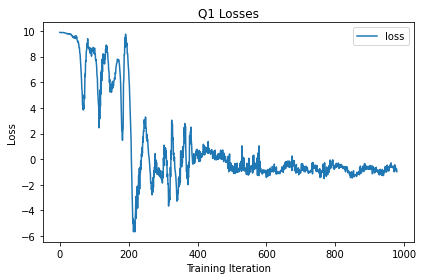

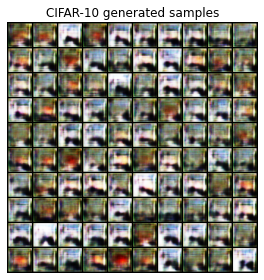

In [ ]:
q1_save_results(q1)

Files already downloaded and verified


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch..:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch..:   0%|          | 0/391 [00:00<?, ?it/s]

..........Inception score: 1.7342333


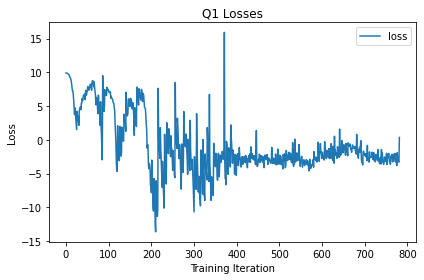

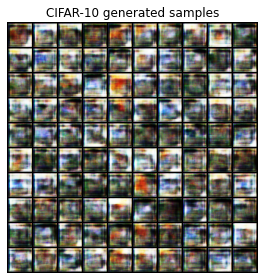

In [ ]:
q1_save_results(q1)

# Question 2: Representation Learning with BiGAN on MNIST

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


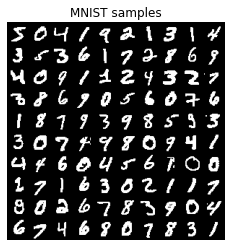

In [ ]:
visualize_q2_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


In [5]:
class G(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512, affine=False),
            nn.Linear(512, out_dim),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.model(z).reshape(-1, 1, 28, 28)


class D(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim + out_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512, affine=False),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, z):
        return self.model(torch.cat((x, z), dim=1))


class E(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512, affine=False),
            nn.Linear(512, out_dim),
        )

    def forward(self, x):
        return self.model(x.reshape(x.shape[0], -1))

In [6]:
class BiGAN(nn.Module):
    def __init__(self, z_dim, x_dim=784):
        super().__init__()
        self.z_dim = z_dim
        self.x_dim = x_dim

        self.generator = G(z_dim, x_dim)
        self.discriminator = D(x_dim, z_dim)
        self.encoder = E(x_dim, z_dim)
        
        self.classifier = nn.Linear(z_dim, 10)
        self.classifier_optim = Adam(self.classifier.parameters(), lr=1e-3)

    def reset_classifier(self):
        self.classifier = nn.Linear(self.z_dim, 10)
        self.classifier_optim = Adam(self.classifier.parameters(), lr=1e-3)
        self.to(device)

    def minmax_loss(self, x_real):
        batch_size = x_real.shape[0]

        z_fake = torch.randn(batch_size, self.z_dim).to(device) # .type_as(x_real)
        z_real = self.encoder(x_real).reshape(batch_size, -1)

        x_fake = self.generator(z_fake).reshape(batch_size, -1)
        x_real = x_real.reshape(batch_size, -1)

        return -(self.discriminator(x_real, z_real)).log().mean() - (1 - self.discriminator(x_fake, z_fake)).log().mean()

    def fit(self, dataloader, num_epochs, lr, weight_decay):
        losses = []

        g_optim = Adam(
            list(self.generator.parameters()) + list(self.encoder.parameters()), 
            lr=lr, betas=(0.5, 0.999), weight_decay=weight_decay)
        d_optim = Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=weight_decay)

        g_scheduler = LambdaLR(g_optim, lambda epoch: (num_epochs - epoch) / num_epochs, last_epoch=-1)
        d_scheduler = LambdaLR(d_optim, lambda epoch: (num_epochs - epoch) / num_epochs, last_epoch=-1)

        for epoch in trange(num_epochs, desc="Training"):
            for batch, _ in tqdm(dataloader, desc="Batch", leave=False):
                batch = batch.to(device)

                d_loss = self.minmax_loss(batch)

                d_optim.zero_grad()
                d_loss.backward()
                d_optim.step()

                g_loss = -self.minmax_loss(batch)

                g_optim.zero_grad()
                g_loss.backward()
                g_optim.step()

                losses.append(d_loss.detach().cpu().numpy())

            g_scheduler.step()
            d_scheduler.step()

        return np.array(losses)

    def fit_classifier(self, dataloader, num_epochs):
        losses = []
        self.encoder.eval()

        for epoch in trange(num_epochs, desc="Train classifier"):
            epoch_losses = []
            for x, y in tqdm(dataloader, desc="Epoch", leave=False):
                x = x.to(device)
                y = y.to(device)

                with torch.no_grad():
                    z = self.encoder(x)

                y_pred = self.classifier(z)
                loss = F.cross_entropy(y_pred, y)

                self.classifier_optim.zero_grad()
                loss.backward()
                self.classifier_optim.step()

                epoch_losses.append(loss.detach().item())

            losses.append(np.mean(epoch_losses))

        self.train()

        return losses

    @torch.no_grad()
    def sample(self, num_samples):
        z = torch.randn(num_samples, self.z_dim).to(device)
        return self.generator(z).cpu().numpy()

    @torch.no_grad()
    def recon(self, x):
        z = self.encoder(x.to(device))
        recons = self.generator(z)
        return recons

## Solution

In [7]:
def q2(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    """ YOUR CODE HERE """
    train_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, pin_memory=True)
    # test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False, pin_memory=True)

    gan = BiGAN(z_dim=50).to(device)

    rand_class_losses = gan.fit_classifier(train_dataloader, num_epochs=50)
    gan.reset_classifier()
    
    gan_losses = gan.fit(train_dataloader, num_epochs=100, lr=2e-4, weight_decay=2.5e-5)
    class_losses = gan.fit_classifier(train_dataloader, num_epochs=50)

    gan.eval()

    samples = gan.sample(num_samples=100).transpose(0, 2, 3, 1) * 0.5 + 0.5

    real = next(iter(train_dataloader))[0][:20]
    recon = gan.recon(real).detach().cpu()
    pairs = ((torch.cat([real, recon]) * 0.5) + 0.5).permute(0, 2, 3, 1).detach().cpu().numpy()

    return gan_losses, samples, pairs, class_losses, rand_class_losses

## Results

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Train classifier:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Batch:   0%|          | 0/157 [00:00<?, ?it/s]

Train classifier:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/157 [00:00<?, ?it/s]

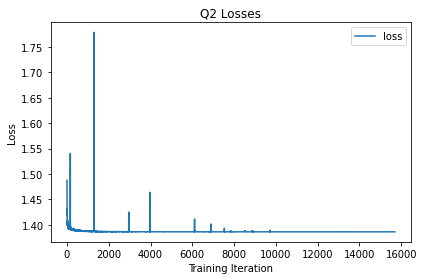

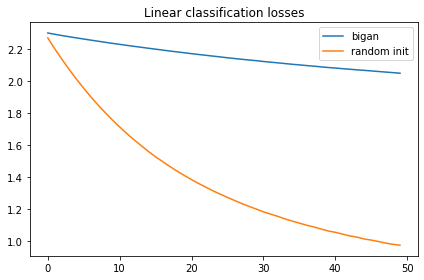

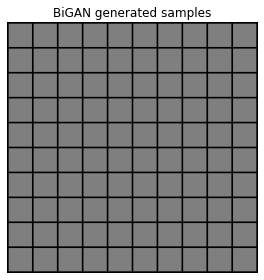

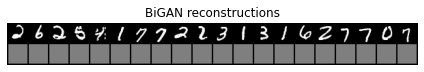

BiGAN final linear classification loss: 2.048059738365708
Random encoder linear classification loss: 0.9749488424343667


In [8]:
q2_save_results(q2) # короче без понятия почему шум, колаб все равно забанил, уже сломал кажется то что было

# Bonus 5: CycleGAN
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

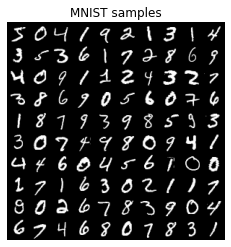

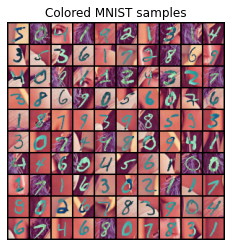

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def b5(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

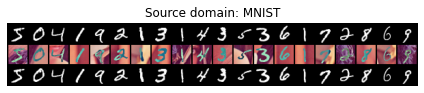

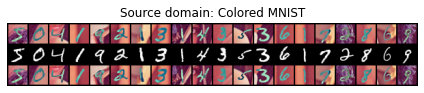

In [ ]:
b5_save_results(b5)